In [63]:
import os
import random

import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

## loading of MuzicBrainz Dataset

In [64]:
artists = pd.read_csv('./mbdump/artist', delimiter='\t', index_col=False,
                      names=['id', 'gid', 'name', 'sort_name', 'begin_date_year', 'begin_date_month', 'begin_date_day',
                             'end_date_year', 'end_date_month', 'end_date_day', 'type', 'area', 'gender', 'comment',
                             'edits_pending', 'last_updated', 'ended', ],
                      na_values='\\N')
artists = artists.set_index('id')

label = pd.read_csv('./mbdump/label', delimiter='\t', index_col=False,
                    names=['id', 'gid', 'name', 'begin_date_year', 'begin_date_month', 'begin_date_day',
                           'end_date_year', 'end_date_month', 'end_date_day', 'label_code', 'type', 'area', 'comment',
                           'edits_pending', 'last_updated', 'ended', ],
                    na_values='\\N')
label = label.set_index('id')

artist_label = pd.read_csv('./mbdump/l_artist_label', delimiter='\t', index_col=False,
                           names=['id', 'link', 'entity0', 'entity1', 'edits_pending', 'last_updated', 'link_order',
                                  'entity0_credit', 'entity1_credit', ],
                           # usecols=['entity0', 'entity1'],
                           na_values='\\N')

event = pd.read_csv('./mbdump/event', delimiter='\t', index_col=False,
                    names=['id', 'gid', 'name', 'begin_date_year', 'begin_date_month', 'begin_date_day',
                           'end_date_year', 'end_date_month', 'end_date_day', 'time', 'type', 'cancelled', 'setlist',
                           'comment', 'edits_pending', 'last_updated', 'ended', ],
                    na_values='\\N'
                    )

artist_event = pd.read_csv('./mbdump/l_artist_event', delimiter='\t', index_col=False,
                           names=['id', 'link', 'entity0', 'entity1', 'edits_pending', 'last_updated', 'link_order',
                                  'entity0_credit', 'entity1_credit', ],
                           # usecols=['entity0', 'entity1'],
                           na_values='\\N')



/Library/Python/3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,6,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Joining

In [65]:
joined = artist_event.join(artists, on='entity0', lsuffix='.event', rsuffix='.artist', how='inner')
full = joined.join(event, on='entity1', lsuffix='.artist', rsuffix='.event', how='inner')

In [66]:
full[['gid.artist', 'name.artist', 'name.event', 'gid.event']].head()

,gid.artist,name.artist,name.event,gid.event
0,db4295e7-06e1-433c-93cb-2f2a86a7ea3a,Wussy,BOB goes Matrix,d801c6c8-7870-4506-9709-af3890bf1e74
1,291f93fb-adfd-430f-aa97-0c34c442d0d7,The Royal Pines,BOB goes Matrix,d801c6c8-7870-4506-9709-af3890bf1e74
3723,db4295e7-06e1-433c-93cb-2f2a86a7ea3a,Wussy,ツアーファイナル@名古屋QUATTRO,e4b9591c-b26b-48a3-8fa1-a54c03e24f18
3724,291f93fb-adfd-430f-aa97-0c34c442d0d7,The Royal Pines,ツアーファイナル@名古屋QUATTRO,e4b9591c-b26b-48a3-8fa1-a54c03e24f18
22530,db4295e7-06e1-433c-93cb-2f2a86a7ea3a,Wussy,Unter einem Dach Festival 2015,26e20d92-8f7d-42e6-8cfd-e4f81b66a7a7


In [67]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143550 entries, 0 to 145324
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id.artist                143550 non-null  int64  
 1   link                     143550 non-null  int64  
 2   entity0                  143550 non-null  int64  
 3   entity1                  143550 non-null  int64  
 4   edits_pending.event      143550 non-null  int64  
 5   last_updated.event       143550 non-null  object 
 6   link_order               143550 non-null  int64  
 7   entity0_credit           3766 non-null    object 
 8   entity1_credit           0 non-null       float64
 9   gid.artist               143550 non-null  object 
 10  name.artist              143549 non-null  object 
 11  sort_name                143549 non-null  object 
 12  begin_date_year.artist   106019 non-null  float64
 13  begin_date_month.artist  49686 non-null   object 
 14  begi

In [68]:
import networkx as nx
from networkx.algorithms import bipartite

In [69]:
artists = list(map(lambda artist: (artist[0], {'name': artist[1]}), full[['gid.artist', 'name.artist']].values))
events = list(map(lambda event: (event[0], {'name': event[1]}), full[['gid.event', 'name.event']].values))
edges = list(map(lambda edge: (edge[0], edge[1]), full[['gid.artist', 'gid.event']].values))

B = nx.Graph()
B.add_nodes_from(artists, bipartite=0)
B.add_nodes_from(events, bipartite=1)
B.add_edges_from(edges)

In [70]:
nx.write_gml(B, 'MusicBrainz.gml')

In [71]:
print(B.edges.__len__())

142647


In [72]:
def network_connected_component_statistics(G, sample_size, name) -> None:
    print(f'number of nodes: {len(G.nodes())}')
    print(f'number of edges: {len(G.edges())}')

    Gcc = max(nx.connected_components(B), key=len)
    giant_component = B.subgraph(Gcc)
    print(f'size of the giant component: {len(giant_component.nodes)}')

    print(f'average clustering coefficient: {nx.average_clustering(B)}')

    os.makedirs('plots/' + name, exist_ok=True)

    x = dict(nx.degree(G)).values()
    plt.hist(x, bins=100)
    plt.title('network degree distribution')
    plt.ylabel('number of nodes')
    plt.yscale('log')
    plt.xlabel('node degree')
    plt.savefig('plots/' + name + '/degree_distribution.pdf')
    plt.close()

    sources = random.sample(tuple(B.nodes()), sample_size)
    targets = random.sample(tuple(B.nodes()), sample_size)

    counter = Counter()
    for source, target in zip(sources, targets):
        try:
            path = nx.shortest_path(B, source, target)
            length = len(path)
            counter[length] += 1
        except:
            pass

    hist = dict(counter)

    plt.bar(hist.keys(), hist.values())
    plt.title('network distance distribution')
    plt.ylabel('number of nodes')
    plt.yscale('log')
    plt.xlabel('distance')
    plt.savefig('plots/' + name + '/distance_distribution.pdf')

number of nodes: 99845
number of edges: 142647
size of the giant component: 80727
average clustering coefficient: 0.0


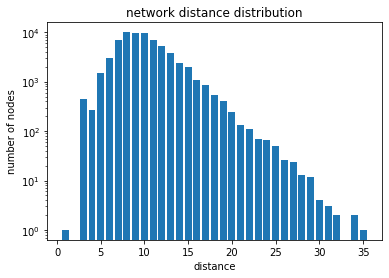

In [73]:
network_connected_component_statistics(B, len(B.nodes), 'MusicBrainz')